## Assignment 1

### Name: Idan Grady
### Student Number 1912976

# Part I. Preparation

First, we load the CIFAR-10 dataset. This might take a couple minutes the first time you do it, but the files should stay cached after that.

In previous parts of the assignment we had to write our own code to use the MNIST dataset, preprocess it, and iterate through it in minibatches; PyTorch provides convenient tools to automate this process for us.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import matplotlib.pyplot as plt

import numpy as np

import torch.nn.functional as F  # functional versions of the modules in torch.nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from torchvision import transforms
from torchvision.transforms import ToPILImage
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
# matplotlib
import matplotlib.pyplot as plt
import multiprocessing as mp
import torch.nn.init as init
import numpy as np

from IPython.display import Image


TRAIN = False


d:\New folder\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 126] The specified module could not be found
  warn(f"Failed to load image Python extension: {e}")


In [2]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10('./assets/datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

cifar10_val = dset.CIFAR10('./assets/datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))

cifar10_test = dset.CIFAR10('./assets/datasets', train=False, download=True, 
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


You have an option to **use GPU by setting the flag to True below**. It is not necessary to use GPU for this assignment, but you can still do so if you desire. In Google Colab, go to Runtime -> Change runtime type -> hardware accelarator --> GPU. Note that if you use it locally and your computer does not have CUDA enabled, `torch.cuda.is_available()` will return False and this notebook will fallback to CPU mode.

The global variables `dtype` and `device` will control the data types throughout this assignment. 

In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print(f"Using device: {device}\n'cuda' means we are using GPU(s), 'cpu' means we are only using CPU.")

Using device: cuda
'cuda' means we are using GPU(s), 'cpu' means we are only using CPU.


# Part II. Barebones PyTorch

PyTorch ships with high-level APIs to help us define model architectures conveniently, which we will cover in Part II of this tutorial. In this section, we will start with the barebone PyTorch elements to understand the autograd engine better. After this exercise, you will come to appreciate the high-level model API more.

We will start with a simple fully-connected ReLU network with two hidden layers and no biases for CIFAR classification. 
This implementation computes the forward pass using operations on PyTorch Tensors, and uses PyTorch autograd to compute gradients. It is important that you understand every line, because you will write a harder version after the example.

When we create a PyTorch Tensor with `requires_grad=True`, then operations involving that Tensor will not just compute values; they will also build up a computational graph in the background, allowing us to easily backpropagate through the graph to compute gradients of some Tensors with respect to a downstream loss. Concretely if x is a Tensor with `x.requires_grad == True` then after backpropagation `x.grad` will be another Tensor holding the gradient of x with respect to the scalar loss at the end.

### PyTorch Tensors: Flatten Function
A PyTorch Tensor is conceptionally similar to a numpy array: it is an n-dimensional grid of numbers, and like numpy PyTorch provides many functions to efficiently operate on Tensors. As a simple example, we provide a `flatten` function below which reshapes image data for use in a fully-connected neural network.

Recall that image data is typically stored in a Tensor of shape N x C x H x W, where:

* N is the number of datapoints
* C is the number of channels
* H is the height of the intermediate feature map in pixels
* W is the height of the intermediate feature map in pixels

This is the right way to represent the data when we are doing something like a 2D convolution, that needs spatial understanding of where the intermediate features are relative to each other. When we use fully connected affine layers to process the image, however, we want each datapoint to be represented by a single vector -- it's no longer useful to segregate the different channels, rows, and columns of the data. So, we use a "flatten" operation to collapse the `C x H x W` values per representation into a single long vector. The flatten function below first reads in the N, C, H, and W values from a given batch of data, and then returns a "view" of that data. "View" is analogous to numpy's "reshape" method: it reshapes x's dimensions to be N x ??, where ?? is allowed to be anything (in this case, it will be C x H x W, but we don't need to specify that explicitly). 

In [4]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image

def test_flatten():
    x = torch.arange(12).view(2, 1, 3, 2)
    print(f"Before flattening: {x}")
    print(f"After flattening: {flatten(x)}")

test_flatten()

Before flattening: tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
After flattening: tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])


### Barebones PyTorch: Two-Layer Network

Here we define a function `two_layer_fc` which performs the forward pass of a two-layer fully-connected ReLU network on a batch of image data. After defining the forward pass we check that it doesn't crash and that it produces outputs of the right shape by running zeros through the network.

You don't have to write any code here, but it's important that you read and understand the implementation.

In [5]:
import torch.nn.functional as F  # useful stateless functions

def two_layer_fc(x, params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass; 
    PyTorch will take care of the backward pass for us.
    
    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.
    
    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).
    
    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """
    # first we flatten the image
    x = flatten(x)  # shape: [batch_size, C x H x W]
    
    w1, w2 = params
    
    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x = F.relu(x.mm(w1))
    x = x.mm(w2)
    return x
    

def two_layer_fc_test():
    hidden_layer_size = 42
    x = torch.zeros((64, 50), dtype=dtype)  # minibatch size 64, feature dimension 50
    w1 = torch.zeros((50, hidden_layer_size), dtype=dtype)
    w2 = torch.zeros((hidden_layer_size, 10), dtype=dtype)
    scores = two_layer_fc(x, [w1, w2])
    print(scores.size())  # you should see [64, 10]

two_layer_fc_test()

torch.Size([64, 10])


### Q1 - Barebones PyTorch: Three-Layer ConvNet

Here you will complete the implementation of the function `three_layer_convnet`, which will perform the forward pass of a three-layer convolutional network. Like above, we can immediately test our implementation by passing zeros through the network. The network should have the following architecture:

1. A convolutional layer (with bias) with `channel_1` filters, each with shape `KW1 x KH1`, and zero-padding of two
2. ReLU nonlinearity
3. A convolutional layer (with bias) with `channel_2` filters, each with shape `KW2 x KH2`, and zero-padding of one
4. ReLU nonlinearity
5. Fully-connected layer with bias, producing scores for C classes.

**HINT**: Check out the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.conv2d.html#torch.nn.functional.conv2d); pay attention to the shapes of convolutional filters!

In [6]:
def three_layer_convnet(x, params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
    
    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    print(f"conv_w1.shape: {conv_w1.shape}")
    print(f"conv_w2: {conv_w2.shape}")
    print(f"fc_w: {fc_w.shape}")
    scores = None
    ################################################################################
    # TODO: Implement the forward pass for the three-layer ConvNet.                #
    ################################################################################
    l_1 = torch.relu(torch.nn.functional.conv2d(x,conv_w1,conv_b1,stride = 1, padding = 2))
    l_2 =  torch.relu(torch.nn.functional.conv2d(l_1,conv_w2,conv_b2,stride = 1, padding =1))

    print(f"L2: {l_2.shape}")
    print(torch.flatten(l_2,start_dim=1).shape)

    scores = torch.nn.functional.linear(torch.flatten(l_2,start_dim=1),fc_w.T, fc_b )
    
    ################################################################################
    #                                 END OF YOUR CODE                             #
    ################################################################################
    return scores

After defining the forward pass of the ConvNet above, run the following cell to test your implementation.

When you run this function, scores should have shape (64, 10).

In [7]:
def three_layer_convnet_test():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]

    conv_w1 = torch.zeros((6, 3, 5, 5), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1 = torch.zeros((6,))  # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    # you must calculate the shape of the tensor after two conv layers, before the fully-connected layer
    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]
three_layer_convnet_test()

conv_w1.shape: torch.Size([6, 3, 5, 5])
conv_w2: torch.Size([9, 6, 3, 3])
fc_w: torch.Size([9216, 10])
L2: torch.Size([64, 9, 32, 32])
torch.Size([64, 9216])
torch.Size([64, 10])


### Barebones PyTorch: Initialization
Let's write a couple utility methods to initialize the weight matrices for our models.

- `random_weight(shape)` initializes a weight tensor with the Kaiming normalization method.
- `zero_weight(shape)` initializes a weight tensor with all zeros. Useful for instantiating bias parameters.

The `random_weight` function uses the Kaiming normal initialization method, described in:

He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

In [8]:
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape) == 2:  # FC weight
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:]) # conv weight [out_channel, in_channel, kH, kW]
    # randn is standard normal distribution generator. 
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2. / fan_in)
    w.requires_grad = True
    return w

def zero_weight(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requires_grad=True)

# create a weight of shape [3 x 5]
# you should see `device='cuda:0'` if you use GPU. 
random_weight((3, 5))


tensor([[ 0.3612, -0.0621, -0.0127,  0.0570,  0.3163],
        [ 0.3290, -1.3146,  0.8990, -0.2322, -0.1838],
        [-0.9929, -0.1307, -0.0903, -0.0413, -1.2448]], device='cuda:0',
       requires_grad=True)

### Barebones PyTorch: Check Accuracy
When training the model we will use the following function to check the accuracy of our model on the training or validation sets.

When checking accuracy we don't need to compute any gradients; as a result we don't need PyTorch to build a computational graph for us when we compute scores. To prevent a graph from being built we scope our computation under a `torch.no_grad()` context manager.

In [9]:
def check_accuracy_part2(loader, model_fn, params):
    """
    Check the accuracy of a classification model.
    
    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model
    
    Returns: Nothing, but prints the accuracy of the model
    """
    split = 'val' if loader.dataset.train else 'test'
    print('Checking accuracy on the %s set' % split)
    num_correct, num_samples = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.int64)
            scores = model_fn(x, params)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f%%)' % (num_correct, num_samples, 100 * acc))

### BareBones PyTorch: Training Loop
We can now set up a basic training loop to train our network. We will train the model using stochastic gradient descent without momentum. We will use `torch.functional.cross_entropy` to compute the loss; you can [read about it here](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html#torch.nn.functional.cross_entropy).

The training loop takes as input the neural network function, a list of initialized parameters (`[w1, w2]` in our example), and learning rate.

In [10]:
def train_part2(model_fn, params, learning_rate):
    """
    Train a model on CIFAR-10.
    
    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD
    
    Returns: Nothing
    """
    for t, (x, y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        # Forward pass: compute scores and loss
        scores = model_fn(x, params)
        loss = F.cross_entropy(scores, y)

        # Backward pass: PyTorch figures out which Tensors in the computational
        # graph has requires_grad=True and uses backpropagation to compute the
        # gradient of the loss with respect to these Tensors, and stores the
        # gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters. We don't want to backpropagate through the
        # parameter updates, so we scope the updates under a torch.no_grad()
        # context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                # Manually zero the gradients after running the backward pass
                w.grad.zero_()

        if t % print_every == 0:
            print('Iteration %d, loss = %.4f' % (t, loss.item()))
            check_accuracy_part2(loader_val, model_fn, params)
            print()

### BareBones PyTorch: Train a Two-Layer Network
Now we are ready to run the training loop. We need to explicitly allocate tensors for the fully connected weights, `w1` and `w2`. 

Each minibatch of CIFAR has 64 examples, so the tensor shape is `[64, 3, 32, 32]`. 

After flattening, `x` shape should be `[64, 3 * 32 * 32]`. This will be the size of the first dimension of `w1`. 
The second dimension of `w1` is the hidden layer size, which will also be the first dimension of `w2`. 

Finally, the output of the network is a 10-dimensional vector that represents the probability distribution over 10 classes. 

You don't need to tune any hyperparameters but you should see accuracies above 40% after training for one epoch.

In [11]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

if TRAIN:
    train_part2(two_layer_fc, [w1, w2], learning_rate)

### Q2 - BareBones PyTorch: Training a ConvNet

In the code box below you should use the functions defined above to train a three-layer convolutional network on CIFAR. The network should have the following architecture:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes

You should initialize your weight matrices using the `random_weight` function defined above, and you should initialize your bias vectors using the `zero_weight` function above.

You don't need to tune any hyperparameters, but if everything works correctly you should achieve an accuracy above 42% after one epoch.

In [12]:
learning_rate = 3e-3

channel_1 = 32
channel_2 = 16


################################################################################
# TODO: Initialize the parameters of a three-layer ConvNet.                    #
################################################################################
conv_w1 = random_weight((channel_1,3, 5, 5))
conv_b1 = zero_weight((channel_1,))
conv_w2 = random_weight((channel_2, channel_1, 3, 3))
conv_b2 = zero_weight((channel_2,))
f = flatten(conv_w2)
print(f.shape)
fc_w =random_weight((32*32*16,10))
fc_b = zero_weight(10,)
################################################################################
#                                 END OF YOUR CODE                             #
################################################################################

params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
print(f"conv_w1: {conv_w1.shape}")
print(f"conv_w2: {conv_w2.shape}")
print(f"conv_b1: {conv_b1.shape}")
print(f"conv_b2: {conv_b2.shape}")
print(f"fc_w: {fc_w.shape}")
print(f"fc_b: {fc_b.shape}")

if TRAIN:
    train_part2(three_layer_convnet, params, learning_rate)

torch.Size([16, 288])
conv_w1: torch.Size([32, 3, 5, 5])
conv_w2: torch.Size([16, 32, 3, 3])
conv_b1: torch.Size([32])
conv_b2: torch.Size([16])
fc_w: torch.Size([16384, 10])
fc_b: torch.Size([10])


# Part III. PyTorch Module API

Barebone PyTorch requires that we track all the parameter tensors by hand. This is fine for small networks with a few tensors, but it would be extremely inconvenient and error-prone to track tens or hundreds of tensors in larger networks.

PyTorch provides the `nn.Module` API for you to define arbitrary network architectures, while tracking every learnable parameters for you. PyTorch also provides the `torch.optim` package that implements all the common optimizers, such as RMSProp, Adagrad, and Adam. It even supports approximate second-order methods like L-BFGS! You can refer to the [doc](http://pytorch.org/docs/master/optim.html) for the exact specifications of each optimizer.

To use the Module API, follow the steps below:

1. Subclass `nn.Module`. Give your network class an intuitive name like `TwoLayerFC`. 

2. In the constructor `__init__()`, define all the layers you need as class attributes. Layer objects like `nn.Linear` and `nn.Conv2d` are themselves `nn.Module` subclasses and contain learnable parameters, so that you don't have to instantiate the raw tensors yourself. `nn.Module` will track these internal parameters for you. Refer to the [doc](http://pytorch.org/docs/master/nn.html) to learn more about the dozens of builtin layers. **Warning**: don't forget to call the `super().__init__()` first!

3. In the `forward()` method, define the *connectivity* of your network. You should use the attributes defined in `__init__` as function calls that take tensor as input and output the "transformed" tensor. Do *not* create any new layers with learnable parameters in `forward()`! All of them must be declared upfront in `__init__`. 

After you define your Module subclass, you can instantiate it as an object and call it just like the NN forward function in part II.

### Module API: Two-Layer Network
Here is a concrete example of a 2-layer fully connected network:

In [13]:
class TwoLayerFC(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        # assign layer objects to class attributes
        self.fc1 = nn.Linear(input_size, hidden_size)
        # nn.init package contains convenient initialization methods
        # http://pytorch.org/docs/master/nn.html#torch-nn-init 
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(hidden_size, num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self, x):
        # forward always defines connectivity
        x = flatten(x)
        scores = self.fc2(F.relu(self.fc1(x)))
        return scores

def test_TwoLayerFC():
    input_size = 50
    x = torch.zeros((64, input_size), dtype=dtype)  # minibatch size 64, feature dimension 50
    print(f"size: {x.shape}")
    model = TwoLayerFC(input_size, 42, 10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_TwoLayerFC()

size: torch.Size([64, 50])
torch.Size([64, 10])


### Q3 - Module API: Three-Layer ConvNet
It's your turn to implement a 3-layer ConvNet followed by a fully connected layer. The network architecture should be the same as in Part II:

1. Convolutional layer with `channel_1` 5x5 filters with zero-padding of 2
2. ReLU
3. Convolutional layer with `channel_2` 3x3 filters with zero-padding of 1
4. ReLU
5. Fully-connected layer to `num_classes` classes

You should initialize the weight matrices of the model using the Kaiming normal initialization method.

**HINT**: Check out the [documentation](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d)

After you implement the three-layer ConvNet, the `test_ThreeLayerConvNet` function will run your implementation; it should print `(64, 10)` for the shape of the output scores.

In [14]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2, num_classes):
        super().__init__()
        ########################################################################
        # TODO: Set up the layers you need for a three-layer ConvNet with the  #
        # architecture defined above.                                          #
        ########################################################################
        self.C1 = torch.nn.Conv2d(in_channels=in_channel, out_channels=channel_1, kernel_size=5, stride=1, padding=2)
        self.C2 = torch.nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=3, stride=1, padding=1)
        self.L1 = torch.nn.Linear(in_features=32*32*channel_2, out_features= num_classes, bias=True)
        ########################################################################
        #                          END OF YOUR CODE                            #       
        ########################################################################

    def forward(self, x):
        scores = None
        ########################################################################
        # TODO: Implement the forward function for a 3-layer ConvNet. you      #
        # should use the layers you defined in __init__ and specify the        #
        # connectivity of those layers in forward()                            #
        ########################################################################
        x = F.relu(self.C1(x))
        print(f"C1: {x.shape}")
        x = F.relu(self.C2(x))
        print(f"C2: {x.shape}")
        x = flatten(x)
        print(x.shape)
        scores = self.L1(x)
        ########################################################################
        #                             END OF YOUR CODE                         #
        ########################################################################
        return scores


def test_ThreeLayerConvNet():
    x = torch.zeros((64, 3, 32, 32), dtype=dtype)  # minibatch size 64, image size [3, 32, 32]
    model = ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores = model(x)
    print(scores.size())  # you should see [64, 10]
test_ThreeLayerConvNet()

C1: torch.Size([64, 12, 32, 32])
C2: torch.Size([64, 8, 32, 32])
torch.Size([64, 8192])
torch.Size([64, 10])


### Module API: Check Accuracy
Given the validation or test set, we can check the classification accuracy of a neural network. 

This version is slightly different from the one in part II. You don't manually pass in the parameters anymore.

In [15]:
def check_accuracy_part34(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

### Module API: Training Loop
We also use a slightly different training loop. Rather than updating the values of the weights ourselves, we use an Optimizer object from the `torch.optim` package, which abstract the notion of an optimization algorithm and provides implementations of most of the algorithms commonly used to optimize neural networks.

In [16]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy_part34(loader_val, model)
                print()

### Module API: Train a Two-Layer Network
Now we are ready to run the training loop. In contrast to part II, we don't explicitly allocate parameter tensors anymore.

Simply pass the input size, hidden layer size, and number of classes (i.e. output size) to the constructor of `TwoLayerFC`. 

You also need to define an optimizer that tracks all the learnable parameters inside `TwoLayerFC`.

You don't need to tune any hyperparameters, but you should see model accuracies above 40% after training for one epoch.

In [17]:
hidden_layer_size = 4000
learning_rate = 1e-2
model = TwoLayerFC(3 * 32 * 32, hidden_layer_size, 10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

if TRAIN:
    train_part34(model, optimizer)

### Q4 -  Module API: Train a Three-Layer ConvNet
You should now use the Module API to train a three-layer ConvNet on CIFAR. This should look very similar to training the two-layer network! You don't need to tune any hyperparameters, but you should achieve above above 45% after training for one epoch.

You should train the model using stochastic gradient descent without momentum.

In [18]:
learning_rate = 3e-3
channel_1 = 32
channel_2 = 16

model = ThreeLayerConvNet(in_channel=3, channel_1=channel_1, channel_2=channel_2, num_classes=10)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

################################################################################
# TODO: Instantiate your ThreeLayerConvNet model and a corresponding optimizer #
################################################################################

################################################################################
#                                 END OF YOUR CODE                             
################################################################################

if TRAIN:
    train_part34(model, optimizer)

# Part IV. PyTorch Sequential API

Part III introduced the PyTorch Module API, which allows you to define arbitrary learnable layers and their connectivity. 

For simple models like a stack of feed forward layers, you still need to go through 3 steps: subclass `nn.Module`, assign layers to class attributes in `__init__`, and call each layer one by one in `forward()`. Is there a more convenient way? 

Fortunately, PyTorch provides a container Module called `nn.Sequential`, which merges the above steps into one. It is not as flexible as `nn.Module`, because you cannot specify more complex topology than a feed-forward stack, but it's good enough for many use cases.

### Q5 - Sequential API: Three-Layer ConvNet
Here you should use `nn.Sequential` to define and train a three-layer ConvNet with the same architecture we used in Part III:

1. Convolutional layer (with bias) with 32 5x5 filters, with zero-padding of 2
2. ReLU
3. Convolutional layer (with bias) with 16 3x3 filters, with zero-padding of 1
4. ReLU
5. Fully-connected layer (with bias) to compute scores for 10 classes


You should optimize your model using stochastic gradient descent with Nesterov momentum 0.9.

Again, you don't need to tune any hyperparameters but you should see accuracy above 55% after one epoch of training.

In [19]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    
channel_1 = 32
channel_2 = 16
learning_rate = 1e-2

################################################################################
# TODO: Rewrite the 3-layer ConvNet with bias from Part III with the           #
# Sequential API.                                                              #
################################################################################
model =  nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=channel_1, kernel_size=5, stride=1, padding=2, bias=True),
    nn.ReLU(),
    nn.Conv2d(in_channels=channel_1, out_channels=channel_2, kernel_size=5, stride=1, padding=2, bias = True),
    nn.ReLU(),
    nn.Flatten(start_dim=1),
    nn.Linear(32*32*channel_2, 10)
)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

################################################################################
#                                 END OF YOUR CODE                             
################################################################################
if TRAIN:
    train_part34(model, optimizer)

# Part V. Q6 - CIFAR-10 Open Challenge

In this section, we need to create a decent model. Experiment with whatever ConvNet architecture you'd like on CIFAR-10.

It is your job to experiment with architectures, hyperparameters, loss functions, and optimizers to train a model that achieves **at least 70%** accuracy on the CIFAR-10 **validation** set within 10 epochs. You can use the check_accuracy and train functions from above. You should use the  `nn.Module` API. 

Here are the official API documentation for each component. One note: what we call in the class "spatial batch norm" is called "BatchNorm2D" in PyTorch.

* Layers in torch.nn package: http://pytorch.org/docs/stable/nn.html
* Activations: http://pytorch.org/docs/stable/nn.html#non-linear-activations
* Loss functions: http://pytorch.org/docs/stable/nn.html#loss-functions
* Optimizers: http://pytorch.org/docs/stable/optim.html


### Things you might try:
- **Filter size**: Above we used 5x5; would smaller filters be more efficient?
- **Number of filters**: Above we used 32 filters. Do more or fewer do better?
- **Pooling vs Strided Convolution**: Do you use max pooling or just stride convolutions?
- **Batch normalization**: Try adding spatial batch normalization after convolution layers and vanilla batch normalization after affine layers. Do your networks train faster?
- **Network architecture**: The network above has two layers of trainable parameters. Can you do better with a deep network? Good architectures to try include:
    - [conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [conv-relu-conv-relu-pool]xN -> [affine]xM -> [softmax or SVM]
    - [batchnorm-relu-conv]xN -> [affine]xM -> [softmax or SVM]
- **Global Average Pooling**: Instead of flattening and then having multiple affine layers, perform convolutions until your image gets small (7x7 or so) and then perform an average pooling operation to get to a 1x1 image picture (1, 1 , Filter#), which is then reshaped into a (Filter#) vector. This is used in [Google's Inception Network](https://arxiv.org/abs/1512.00567) (See Table 1 for their architecture).
- **Regularization**: Add l2 weight regularization, or perhaps use Dropout.

### Tips for training
For each network architecture that you try, you should tune the learning rate and other hyperparameters. When doing this there are a couple important things to keep in mind:

- If the parameters are working well, you should see improvement within a few hundred iterations
- Remember the coarse-to-fine approach for hyperparameter tuning: start by testing a large range of hyperparameters for just a few training iterations to find the combinations of parameters that are working at all.
- Once you have found some sets of parameters that seem to work, search more finely around these parameters. You may need to train for more epochs.
- You should use the validation set for hyperparameter search, and save your test set for evaluating your architecture on the best parameters as selected by the validation set.

### Going above and beyond
If you are feeling adventurous there are many other features you can implement to try and improve your performance. You are **not required** to implement any of these, but don't miss the fun if you have time!

- Alternative optimizers: you can try Adam, Adagrad, RMSprop, etc.
- Alternative activation functions such as leaky ReLU, parametric ReLU, ELU, or MaxOut.
- Model ensembles
- Data augmentation
- New Architectures
  - [ResNets](https://arxiv.org/abs/1512.03385) where the input from the previous layer is added to the output.
  - [DenseNets](https://arxiv.org/abs/1608.06993) where inputs into previous layers are concatenated together.
  - [This blog has an in-depth overview](https://chatbotslife.com/resnets-highwaynets-and-densenets-oh-my-9bb15918ee32)
  
Deliverables:
- Explain what techniques you have implemented and how they improve your model/
- Report the train and validation accuracy of your model (remember, 70% minimal on validation set!).
- Report test set accuracy at the end after parameter tuning. Explain why we do not want to evaluate our test set during trainig.
- 10 correct and 10 incorrect model predictions on the test set.

Let's start!

In [20]:
import torch.nn as nn
import torch

# Example inputs
outputs = torch.randn(1, 10)
target = torch.LongTensor([3])

# Print original shapes
print("Original shapes:")
print(f"Outputs: {outputs.shape}")
print(f"Target: {target.shape}")

# Apply softmax to outputs
outputs_softmax = nn.Softmax(dim=1)(outputs)
print("\nAfter softmax:")
print(f"Outputs: {outputs_softmax}")
print(f"Target: {target}")

# Convert target to one-hot encoding
target_onehot = torch.zeros(1, 10)
target_onehot[0, target] = 1
print("\nAfter one-hot encoding:")
print(f"Outputs: {outputs_softmax}")
print(f"Target: {target_onehot}")

# Compute loss with CrossEntropyLoss
criterion = nn.CrossEntropyLoss()
loss = criterion(outputs, target)
print(f"\nLoss with target as integer: {loss}")

# Compute loss with BCEWithLogitsLoss
criterion_bce = nn.BCEWithLogitsLoss()
loss_bce = criterion_bce(outputs, target_onehot)
print(f"Loss with target as one-hot: {loss_bce}")


Original shapes:
Outputs: torch.Size([1, 10])
Target: torch.Size([1])

After softmax:
Outputs: tensor([[0.0139, 0.0347, 0.1108, 0.0163, 0.1437, 0.0137, 0.0923, 0.1342, 0.2635,
         0.1768]])
Target: tensor([3])

After one-hot encoding:
Outputs: tensor([[0.0139, 0.0347, 0.1108, 0.0163, 0.1437, 0.0137, 0.0923, 0.1342, 0.2635,
         0.1768]])
Target: tensor([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

Loss with target as integer: 4.1182098388671875
Loss with target as one-hot: 0.9200295209884644


In [21]:
################################################################################
# TODO:                                                                        #         
# Experiment with any architectures, optimizers, and hyperparameters.          #
# Achieve AT LEAST 70% accuracy on the *validation set* within 10 epochs.      #
#                                                                              #
# Note that you can use the check_accuracy function to evaluate on either      #
# the test set or the validation set, by passing either loader_test or         #
# loader_val as the second argument to check_accuracy. You should not touch    #
# the test set until you have finished your architecture and hyperparameter    #
# tuning, and only run the test set once at the end to report a final value.   #
################################################################################
pass
################################################################################
#                                 END OF YOUR CODE                             
################################################################################

# You should get at least 70% accuracy
if TRAIN:
    train_part34(model, optimizer, epochs=10)

## Project: "Rotation Invariant"

### Important Note
The model was evaluated and run using PyCharm rather than Jupyter. The need for debugging and the flexibility to leverage a GPU for quicker training were the driving factors in choosing PyCharm. An additional file containing the training loop and model was included to make it easier to run the model without the need of a Jupyter notebook. So, each output figures (for testing and validation training etc.. ) were simply inserted in the same location as it had been stored in the previous file.

### Introduction

The "Rotation Invariant" research investigates how to build a simple GCNN (geometric convolutional neural network) model that is rotation-invariant. The model is implemented in PyTorch as rotaClass.

The number of input channels, the number of output channels, the kernel size, and a standard deviation value are all inputs to the rotaClass model. It has four convolutional layers with rotating kernels, shared weights determined by nn.Parameter, and shared weights.

The Xavier normal initialization method is used to initialize the shared weights. Utilizing nn.Conv2d, the four convolution layers are produced and initialized with the shared weights. The shared weight matrix was rotated by 90, 180, and 270 degrees along the second and third dimensions to create a rotated kernel for each of the four convolution layers.

The input is sent through each of the four convolution layers separately in the rotaClass model's forward technique, and the outputs are stacked along a new dimension. The final output, which is rotation-invariant, is produced via max pooling over this extra dimension.

### First, Lets explore why we need it at the first place

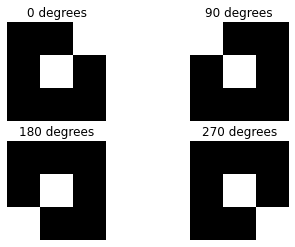

In [23]:
import numpy as np
import torch.nn as nn
def rotate(x: torch.Tensor, r: int) -> torch.Tensor:
    # Method which implements the action of the group element `g` indexed by `r` on the input image `x`.
    # The method returns the image `g.x`
    # note that we rotate the last 2 dimensions of the input, since we want to later use this method to rotate minibatches containing multiple images
    return x.rot90(r, dims=(-2, -1))


def plot_rotated_kernel(kernel: torch.Tensor, r: int):
    kernels = []
    loop_kernel = kernel
    fig, axs = plt.subplots(2, 2)

    for i in range(r):
        loop_kernel = torch.rot90(loop_kernel, k=1, dims=[2, 3])
        kernels.append(loop_kernel)

    for i in range(r):
        row = i // 2
        col = i % 2
        axs[row, col].imshow(kernels[i][0][0].detach().cpu().numpy(), cmap='gray')
        axs[row, col].set_title(f'{i * 90} degrees')
        axs[row, col].axis('off')

    plt.show()

def text_plot_Example(x,r):
    filter3x3 = torch.randn(1, 1, 3, 3)
    print(filter3x3)
    plt.imshow(filter3x3[0, 0].numpy())
    plt.title('Filter')
    plt.show()
    gx = rotate(x, r)

    psi_x = torch.conv2d(x, filter3x3, bias=None, padding=1)
    psi_gx = torch.conv2d(gx, filter3x3, bias=None, padding=1)

    g_psi_x = rotate(psi_x, r)

    plt.imshow(g_psi_x[0, 0].numpy())
    plt.title('$g.\psi(x)$')
    plt.show()

    plt.imshow(psi_gx[0, 0].numpy())
    plt.title('$\psi(g.x)$')
    plt.show()


out_channels =1
in_channels =3
kernel_size =3
x =  nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
plot_rotated_kernel(x, 4)

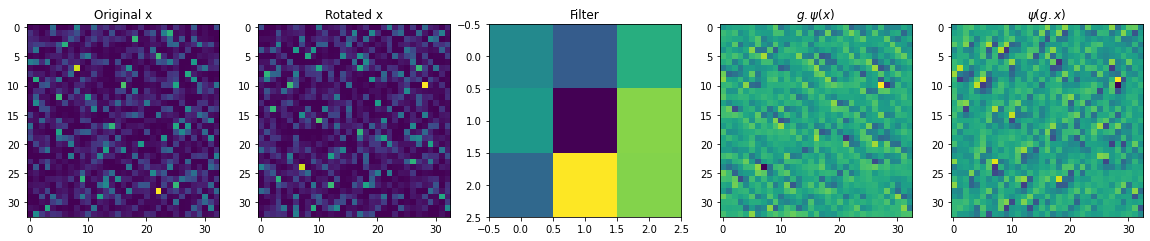

In [24]:
x = torch.randn(1, 1, 33, 33)**2

# Rotate x
r = 1
gx = rotate(x, r)

# Define filter and convolutions
filter3x3 = torch.randn(1, 1, 3, 3)
psi_x = torch.conv2d(x, filter3x3, bias=None, padding=1)
psi_gx = torch.conv2d(gx, filter3x3, bias=None, padding=1)
g_psi_x = rotate(psi_x, r)

# Plot all images in subplots
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# Plot original x
axs[0].imshow(x[0, 0].numpy())
axs[0].set_title('Original x')

# Plot rotated x
axs[1].imshow(gx[0, 0].numpy())
axs[1].set_title('Rotated x')

# Plot filter
axs[2].imshow(filter3x3[0, 0].numpy())
axs[2].set_title('Filter')

# Plot g.psi(x)
axs[3].imshow(g_psi_x[0, 0].numpy())
axs[3].set_title('$g.\psi(x)$')

# Plot psi(g.x)
axs[4].imshow(psi_gx[0, 0].numpy())
axs[4].set_title('$\psi(g.x)$')

plt.show()


### Conclusion

It is evident that even with a simple 90-degree rotation, we cannot directly relate the output of the original input with that of its rotated version. The only way to establish a relationship between the two is through a rotation operation.

### Can we do better?

First, lets created a rotation class with shared weights

In [25]:
#defomd class rotation


class rotaClass(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, std=0.01):
        super(rotaClass, self).__init__()

        self.kernel_size = kernel_size

        # define shared weights using nn.Parameter
        self.weight1 = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size))
        init.xavier_normal_(self.weight1)
        self.bias1 = nn.Parameter(torch.zeros(out_channels), requires_grad=True)
        assert self.weight1.shape == (out_channels, in_channels, kernel_size, kernel_size)

        # define four convolution layers with rotated kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, padding=1)
        self.conv1.weight = nn.Parameter(self.weight1)
        self.conv1.bias = nn.Parameter(self.bias1)

        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.conv2.weight = nn.Parameter(
            torch.rot90(self.weight1, k=1,
                        dims=[2, 3]))  # dims=[2, 3] rotates the second the third dimention / Rotate 90
        self.conv2.bias = nn.Parameter(self.bias1)

        self.conv3 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.conv3.weight = nn.Parameter(
            torch.rot90(self.weight1, k=2,
                        dims=[2, 3]))  # dims=[2, 3] rotates the second the third dimention /Rotate 180

        self.conv3.bias = nn.Parameter(self.bias1)

        self.conv4 = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=1)
        self.conv4.weight = nn.Parameter(
            torch.rot90(self.weight1, k=3,
                        dims=[2, 3]))  # dims=[2, 3] rotates the second the third dimention. /Rotate 270
        self.conv4.bias = nn.Parameter(self.bias1)

    def forward(self, x):
        # apply four convolution layers separately
        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)

        # stack outputs and perform max pooling over new dimension
        x = torch.stack((x1, x2, x3, x4), dim=1)
        x, _ = torch.max(x, dim=1, keepdim=True)
        x = x.squeeze(dim=1)
        return x
    def plotWeights(self):
        plot_rotated_kernel(self.weight1, 4)

### Model

A neural network model for image categorization is called RotConvNet.  This model can extract a greater variety of information from input photos since it has many convolutional layers with rotated filters. In order to enhance performance and avoid overfitting, the model additionally makes use of batch normalization and dropout regularization. The final output is created by applying convolutional layers to the input image and then passing the result through numerous fully connected layers. A certain number of input channels must be provided for the model to function, and a certain number of output channels must be produced.

In [26]:
# Model

class RotConvNet(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, std=0.01):
        super(RotConvNet, self).__init__()

        self.kernel_size = kernel_size
        self.std = std
        self.dropout0 = nn.Dropout(p=0.2)
        self.dropout1 = nn.Dropout(p=0.3)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.3)

        self.Rot_1 = rotaClass(in_channels, out_channels*5, 3, std)
        self.BN_1 = nn.BatchNorm2d(out_channels*5)
        self.Rot_2 = rotaClass(out_channels*5, out_channels*20, 3, std)
        self.BN_2 = nn.BatchNorm2d(out_channels*20)
        self.Rot_3 = rotaClass(out_channels*20, out_channels*10, 3, std)
        self.BN_3 = nn.BatchNorm2d(out_channels*10)
        self.Rot_4 = rotaClass(out_channels*10, out_channels*4, 3, std)
        self.BN_4 = nn.BatchNorm2d(out_channels*4)
        self.Rot_5 = rotaClass(out_channels*4, out_channels, 3, std)
        self.BN_5 = nn.BatchNorm2d(out_channels)

        self.FC = nn.Linear(out_channels * 32 * 32, out_channels*6)
        self.FC1 = nn.Linear(out_channels*6 , out_channels)

    def forward(self, x):
        # apply four convolution layers separately

        x =self.Rot_1(x)
        x = nn.functional.relu(x)
        x= self.dropout0(x)
        x =self.Rot_2(x)
        x =self.BN_2(x)
        x = nn.functional.relu(x)
        x = self.dropout1(x)
        x =self.Rot_3(x)
        x =self.BN_3(x)
        x = nn.functional.relu(x)
        x =self.Rot_4(x)
        x = self.dropout3(x)
        x = nn.functional.relu(x)
        x =self.Rot_5(x)
        x =self.BN_5(x)
        x = nn.functional.relu(x)

        x = torch.flatten(x, 1)

        x = self.dropout1(x)
        x = nn.functional.relu(self.FC(x))
        x =nn.functional.relu(self.FC1(x))
        return x, F.softmax(x, dim=1)
    
    def load_weights(self, path):
        self.load_state_dict(torch.load(path))


### Lets observe how one weights look like

This can be done simply via the function `plotWeights()` which is in each `self.Rot_i \in [1,2,3,4,5]`

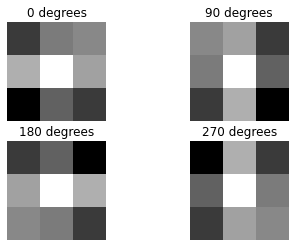

In [ ]:
import torch.nn.init as init

test_model = RotConvNet(in_channels=3, out_channels=10, kernel_size=3)
test_model.to(device)

test_model.Rot_1.plotWeights()


In [27]:
mp.set_start_method('spawn')

batch_size = 35
output_dim = 10
Num_epoch = 75
LR = 0.0002
in_channels = 3
out_channels = 10
kernel_size = 3
ratio_T_T = 0.7

# Define transform to normalize the data
transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
)

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Split dataset into training, validation, and test sets
train_size = int(ratio_T_T * len(trainset))
val_size = int((1.2-ratio_T_T)/2 * len(trainset))
test_size = len(trainset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    trainset, [train_size, val_size, test_size])

# Create data loaders for training, validation, and test sets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                        shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                            shuffle=True, num_workers=2)

# Define the model
model = RotConvNet(in_channels=in_channels, out_channels=out_channels, kernel_size=in_channels)
model.to(device)
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

train_losses = []
train_accuracy = []
val_losses_list = []
val_accuracy_list = []
Test_losses = []
Test_accuracy = []
noisypicsdisplay = []
predictedNoisy = []

best_accuracy = 0.0

if TRAIN:
    for epoch in range(Num_epoch):
        running_loss = 0.0
        T_correct = 0
        correct = 0
        total = 0

        # Train
        model.train()
        for i, data in enumerate(tqdm(trainloader,desc="Epoch {}/{}".format(epoch + 1, Num_epoch))):
            # Get the inputs and labels
            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()
            digits, outputs = model(inputs)
            loss = criterion(digits, labels)
            _, predicted = torch.max(outputs.data, 1)

            loss.backward()
            optimizer.step()

            # Print statistics
            running_loss += loss.item()
            total += labels.size(0)
            T_correct += (predicted == labels).sum().item()
            if i % (1000-1) == 0 :
                accuracy = 100 * T_correct / total
                print('[%d, %5d] loss: %.3f, accuracy: %.2f %%' %
                        (epoch + 1, i + 1, running_loss / len(trainloader), accuracy))

        train_loss = running_loss / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy.append(100 * T_correct / total)

        model.eval()
        val_loss = 0
        total = 0
        val_accuracy = 0
        with torch.no_grad():
            for data in tqdm(valloader):
                inputs, labels = data[0].to(device), data[1].to(device)
                total += labels.size(0)

                outputs = model(inputs)[1]
                val_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                val_accuracy += (predicted == labels).sum().item()

            val_loss /= len(valloader)

            val_losses_list.append(val_loss)
            val_accuracy_list.append(100 * val_accuracy / total)


        print('Test Accuracy of the model on the 10000 test images: {:.4f} %'.format(100 * val_accuracy / total))

        # Evaluation
        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        correct_noisy = 0
        total_noisy = 0
        with torch.no_grad():
            for data in tqdm(testloader):
                inputs, labels = data[0].to(device), data[1].to(device)

                outputs = model(inputs)[1]
                test_loss += criterion(outputs, labels).item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                outputs_Noisy = model(inputs)[1]
                test_loss += criterion(outputs_Noisy, labels).item()
                _, predicted_noisy = torch.max(outputs_Noisy.data, 1)
                total_noisy += labels.size(0)
                correct_noisy += (predicted_noisy == labels).sum().item()

            test_loss /= len(testloader)
            Test_losses.append(test_loss)
            Test_accuracy.append(100 * correct_noisy / total)

            if epoch % 3 == 0:
                noisypicsdisplay.append(inputs[0, 0, :, :])
                predictedNoisy.append(predicted_noisy[0])

            print('Test Accuracy of the model on the 10000 test images: {:.4f} %'.format( 100*correct / total))

        # Save model parameters if the current accuracy is better than the best one so far
        current_accuracy = 100 * correct / total
        if current_accuracy > best_accuracy:
            print("Parameters Mode Updated")
            best_accuracy = current_accuracy
            torch.save(model.state_dict(), "best_model.pth")



    # Plot the training and validation loss/accuracy after each epoch
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    ax1.plot(train_losses, label="Training Loss")
    ax1.plot(val_losses_list, label="Validation Loss")
    #  ax1.plot(Test_losses, label="Test Loss")

    ax1.set_title("Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2.plot(train_accuracy, label="Training Accuracy")
    ax2.plot(val_accuracy_list, label="Validation Accuracy")
    #  ax2.plot(Test_accuracy, label="Test Accuracy")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.legend()

    plt.tight_layout()

    # Save the plot to a file
    plt.savefig(f"epoch_{epoch+1}.png")
    plt.close()

print('Finished Training')

Files already downloaded and verified
Finished Training


## Result

### Training visualisation

For the training loop, I use a `learning rate= 0.0002`, `Num_epoch = 20` and `batchsize = batch_size`.

![<caption>](outputvisu.png) 

The model's accuracy could certainly be increased, as the pace of progress begins to decline at 73%. Overfitting is a regular occurrence that causes this. I am still happy with the outcomes, though, given the main goal of this research was to investigate `GCNN` rather than create the best model.
It makes sense to infer that if we kept training the model longer, overfitting would start to increase the validation loss once more. The model grows more specialized and may struggle to generalize successfully to new, untried data as it keeps learning and changing its parameters to better fit the training data.

### Lets see.... what and why I even started with is. How does it perform when we rotating the image :)




### Reflection

This model offers a number of advantages that help it perform well when used for image processing jobs. The usage of rotated kernels, which enables the model to capture a larger variety of information in the input image, is one of its main advantages. To do this, rotate the filters by 90 degrees in order to extract various features.
Weight sharing, which minimizes the number of parameters and speeds up training by using less memory, is another advantage of the model. By normalizing the output of the previous layer and minimizing the internal covariate shift, the usage of batch normalization layers also aids in improving the model's convergence.
The model's performance on some tasks is, however, constrained by a few flaws. For example, the model might not be successful on tasks that call for the detection of extremely abstract or complicated aspects in images, as the rotated kernels might not be able to adequately capture such features. Also, it appears that the model overfits based on the outcome. Although this may have been avoided or adjusted by raising the dropout rate or using other strategies, it was sufficient for this experiment.

In [28]:
if  TRAIN:
    # Load model
    model = RotConvNet(in_channels, out_channels, kernel_size)
    model.load_weights("best_model.pth")
    model.eval()



| <img src="correct_.png"> | <img src="Incorrect_.png"> |
|:---:|:---:|
| *Correct Classification* | *Incorrect Classification* |

### Lets dig a little deeper! 
Lets observe two things, whether the output of `(1,10)` is rotational invariant, and if the model predicts the same result no matter the rotation of the input.
For this, I constructed a simple loop over the test set

In [29]:
# if you want to run it
RUN= False

if RUN:

 # Initialize lists to store correct and incorrect predictions
    correct_predictions = []
    incorrect_predictions = []

    # Loop through the test data and make predictions
    with torch.no_grad():
        for data in tqdm(testloader):
            inputs, labels = data[0].to(device), data[1].to(device)

            outputs = model(inputs)[1]
            _, predicted = torch.max(outputs.data, 1)
            correct_mask = (predicted == labels)

            # Append correct predictions to the correct_predictions list
            for i in range(len(labels)):
                if correct_mask[i]:
                    if len(correct_predictions) < 10:
                        correct_predictions.append((inputs[i], predicted[i], labels[i]))

            # Append incorrect predictions to the incorrect_predictions list
            for i in range(len(labels)):
                if not correct_mask[i]:
                    if len(incorrect_predictions) < 10:
                        incorrect_predictions.append((inputs[i], predicted[i], labels[i]))

    # Plot the correct predictions
    fig, axs = plt.subplots(2, 5, figsize=(13, 8))
    fig.suptitle('Correct Predictions')
    for i, (image, predicted_label, true_label) in enumerate(correct_predictions):
        row = i // 5
        col = i % 5
        axs[row, col].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        axs[row, col].set_title(f'Predicted: {predicted_label}, True: {true_label}')
        axs[row, col].axis('off')

    fig, axs = plt.subplots(5, 5, figsize=(13, 8))
    fig.suptitle('Correct Classification-Rotated Images')
    amount_of_pics = 5
    for i, (image, predicted_label, true_label) in enumerate(correct_predictions[:amount_of_pics]):
        for j in range(4):
            axs[i, 0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
            rotated_image = rotate(image, j )
            output_field, output = model((rotated_image.unsqueeze(0)))
            _, predicted = torch.max(output.data, 1)
            output_field = output_field.squeeze(0)
            row = i
            col = j+1
            axs[row, col].imshow(output_field.cpu().detach().numpy().reshape(2, 5))
            if(row==0):
                axs[0, col].set_title(f'Field Rotation: {j * 90} deg.\nPredicted: {predicted.item()}, True: {true_label}')
            else:
                axs[row, col].set_title(
                    f'Predicted: {predicted.item()}, True: {true_label}')
            axs[row, col].axis('off')

    fig, axs = plt.subplots(5, 5, figsize=(13, 8))
    fig.suptitle('Incorrect Classification-Rotated Images')
    for i, (image, predicted_label, true_label) in enumerate(incorrect_predictions[:amount_of_pics]):
        for j in range(4):
            axs[i, 0].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
            rotated_image = rotate(image, j )
            output_field, output = model((rotated_image.unsqueeze(0)))
            _, predicted = torch.max(output.data, 1)

            output_field = output_field.squeeze(0)
            row = i
            col = j+1
            axs[row, col].imshow(output_field.cpu().detach().numpy().reshape(2, 5))
            if(row==0):
                axs[0, col].set_title(f'Field Rotation: {j * 90} deg.\nPredicted: {predicted.item()}, True: {true_label}')
            else:
                axs[row, col].set_title(
                    f'Predicted: {predicted.item()}, True: {true_label}')

            axs[row, col].axis('off')

    # Plot the incorrect predictions
    fig, axs = plt.subplots(2, 5, figsize=(10, 5))
    fig.suptitle('Incorrect Predictions')
    for i, (image, predicted_label, true_label) in enumerate(incorrect_predictions):
        row = i // 5
        col = i % 5
        axs[row, col].imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        axs[row, col].set_title(f'Predicted: {predicted_label}, True: {true_label}')
        axs[row, col].axis('off')

    plt.show()

### Result

I studied how my model responded to input photographs that had been rotated. I did this by plotting the output for each of the four potential "90*j" rotations for both correct and incorrect classifications. It's important to note that I used the (1,10) output, despite its small dimension, as the activation field for this analysis.



| <img src="correct_class_rot.png"> | <img src="incorrect_class_rot.png"> |
|:---:|:---:|
| *Correct Classification* | *Incorrect Classification* |

There are two key conclusions that can be drawn from the two plots. First, regardless of whether the classification was accurate or inaccurate, it was found that rotating the input image had an impact on both the output activation field and the model's predictions. Remarkably, the model's predictions were more accurate when the input image was a little bit darker than usual. Also, it was discovered that when the image was rotated, the model frequently misidentified some classes, including `2` and `0` which have sharper edges. 

![<caption>](closeUP_12.jpg)


It was a fascinating observation, as it became evident why this mistake arose upon closer investigation. Yet, it is also clear that the output's activation field did not match up via a group rotation operation, failing to meet the equivariant condition.

There are several potential reasons for this subpar performance, but I think the most logical one is that the model isn't complex enough and that it needs further training. Despite these outcomes, I still think this project was successful because I enjoyed this challenge quite a bit!

### Thank you
Idan Grady